# BPS Bus Route Optimization

### Problem Statement
The Boston Public Schools has released an RFP seeking to find a solution to optimize their strategy for student transportation to and from school. 

From BPS: "In FY16, transportation costs accounted for \$110 million or 11% of the district’s budget. On a per pupil basis, BPS’s transportation cost is the second highest and more than five times the average of the largest 200 public school districts... While only limited benchmarking exists, a report from the Council of Great City Schools found that BPS has higher costs per mile, costs per rider, and costs per bus compared to other similar school districts."



### Outcome
The expected outcome of this project is a modeled system of a minimized number of bus stops and routes that provide efficient transportation for every student to and from school. The system will be measured by comparison to the baseline of the existing BPS transportation system as described below:

Scenario | # of required busses |Service hours | Service miles
---| ---| ---
current BPS system | 630 | 3,600 | 44,500

### Approach

1. Data Visualization and Exploration: I will start by visualizing the dsitribution of students across Boston using the matplotlib Basemap package and the transportation flow across the city using a flare dependancy graph. Other visualization techniques TBD.
2. Bus Stop Optimization: I hypothesize that by reducing the number of bus stops, the number of service miles and hours will reduce, creating a more efficient system. In order to model this, I will look to highly dense areas and students' maximum walking distance to see if any walking radii overlap. If a student's max walking distance overlaps with that of another student, there is a potential for stops to be combined.
3. 
4. 

### The Data\*

BPS has made available a dataset capturing information for 90 schools and nearly 5000 students. The feautres included in the dataset are as follows:

Variable | Description | Type of Variable
---| ---| ---
Street Number | House number of student | continuous integer
Street Name |  Name of the street on which the student lives | categorical string
Zip Code | Zip Code in which the student lives | categorical integer 
Latitude | Geodetic coordinate system in decimal degrees | continuous float
Longitude | Geodetic coordinate system in decimal degrees | continuous float
Pickup Type | Corner or Door-to-Door | categorical string
Grade | Grade of the student | categorical integer
Geocode | BPS tracks various neighborhoods by census ‘geocodes’ which we use to analyze student neighborhoods | continuous integer
Neighborhood Safety Score | Based on amount of reported violent crime in neighborhood -- 7 = high level and 1 represents a low level | categorical integer
MaxWalk | Maximum distance student should walk to a stop. Actual walking distance along a common path. Each student will have specific max walking distance based on their grade and rates of reported crime within neighborhood | continuous float
Assigned School | School student is required to be transported to and from each day | categorical string
Current School Start | Arrive at school between 10-15 minutes before the start of school. While the bus needs to arrive 10-15 minutes before the start of school, the bus should plan to leave at the start of school. This allows time for buses to unload and builds in “recovery time” to account for unexpected delays on the route | time
Current School End | Time between school start time and school end time is the length of the school day for that school. Assume all students go home at the end of the day (i.e., they attend no after school activities). As detailed in Appendix 1: Rules of the Road buses should arrive by the school’s end time and leave no later than 15 minutes afterward | time
School Address | Full address of school | categorical string
School Lat | Geodetic coordinate system in decimal degrees | continuous float
School Long | Geodetic coordinate system in decimal degrees | continuous float


\* The data provided by BPS is not acutal student information. In order to protect students' safety and privay the data provided by the BPS is only representative of student information.

### Initial Setup and Package Import

In [46]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
import sklearn as sk

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Load Data

In [47]:
df = pd.read_csv('https://raw.githubusercontent.com/tylershannon/BPS-BusRouteOptimization/master/Data/BPS-StudentInformation.csv')

# 1. Data Visualization and Exploration

Display data

In [48]:
df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867


Create dataframe of schools and their locations (constrained to unique instances)

In [49]:
SchoolLoc = pd.DataFrame(df.AssignedSchool.unique())
SchoolLoc['SchoolLat'] = df.SchoolLat
SchoolLoc['SchoolLong'] = df.SchoolLong

Count the number of instances for the different types of bus stops

In [51]:
df['PickupType'].value_counts()

Corner        2922
D2D           2036
Wheelchair      40
Name: PickupType, dtype: int64

Make new feature for flexability of stop location based on type of bus stop

In [52]:
df['StopFlex'] = 0.0

for i in range(len(df.PickupType)):
    if df.PickupType[i] == 'Corner':
        df.StopFlex[i] = df.MaxWalk[i]

df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong,StopFlex
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075,0.5
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084,0.4
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053,0.0
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552,0.4
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867,0.0


# 1a. Data Visualization- Create Map and Scatter Plot

Resize figures

In [124]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

Crete Basemap instance

In [102]:
m = Basemap(resolution='f', #c, l, i, h, f, or None
           projection='merc',
           lat_0=42.321827, lon_0=-71.081543,
           llcrnrlon=-71.198616, llcrnrlat=42.227755, urcrnrlon=-70.941811, urcrnrlat=42.403939)

Define Map features

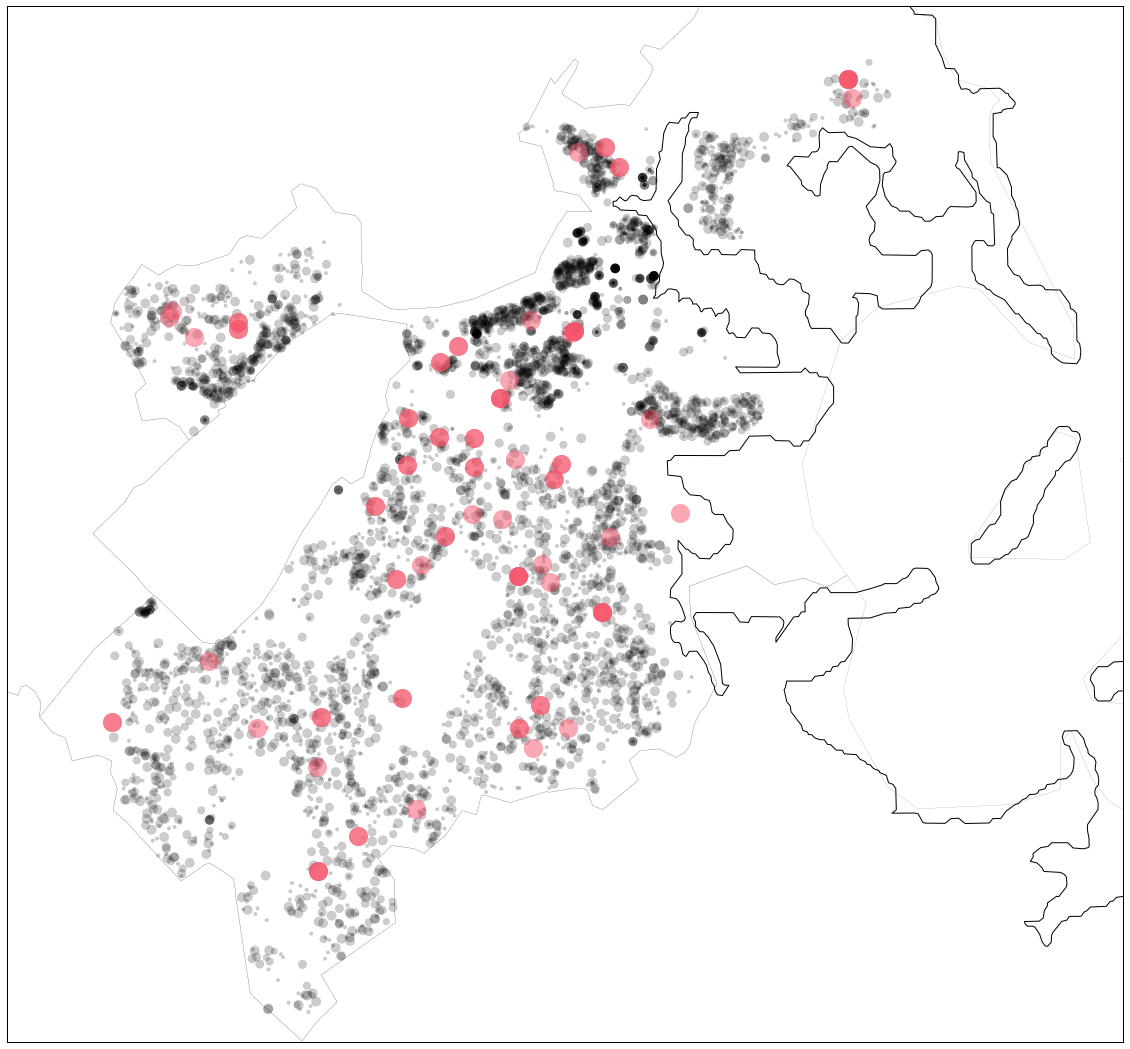

In [125]:
m.drawmapboundary(fill_color='#ffffff')
m.fillcontinents(color='#ffffff', lake_color='#ffffff', alpha=0)
m.drawcoastlines()
m.drawcounties()

stoplons = df.Long
stoplats = df.Lat

schoollons = SchoolLoc.SchoolLong
schoollats = SchoolLoc.SchoolLat

stopx, stopy = m(list(stoplons), list(stoplats))
schoolx, schooly = m(list(schoollons), list(schoollats))

size = df.StopFlex * 600 + 50

m.scatter(stopx, stopy, marker='.', s = size, color = 'k', alpha = .2)
m.scatter(schoolx, schooly, marker = 'o', s = 350, c = '#F6546A', alpha=0.5)
#m.readshapefile('/Users/tylershannon/Desktop/bos_land/bos_land', 'bosshape')

plt.savefig('BPS_AllSchools', bbox_inches='tight')

# 1b. Data Visualization - Individual School Distribution Map

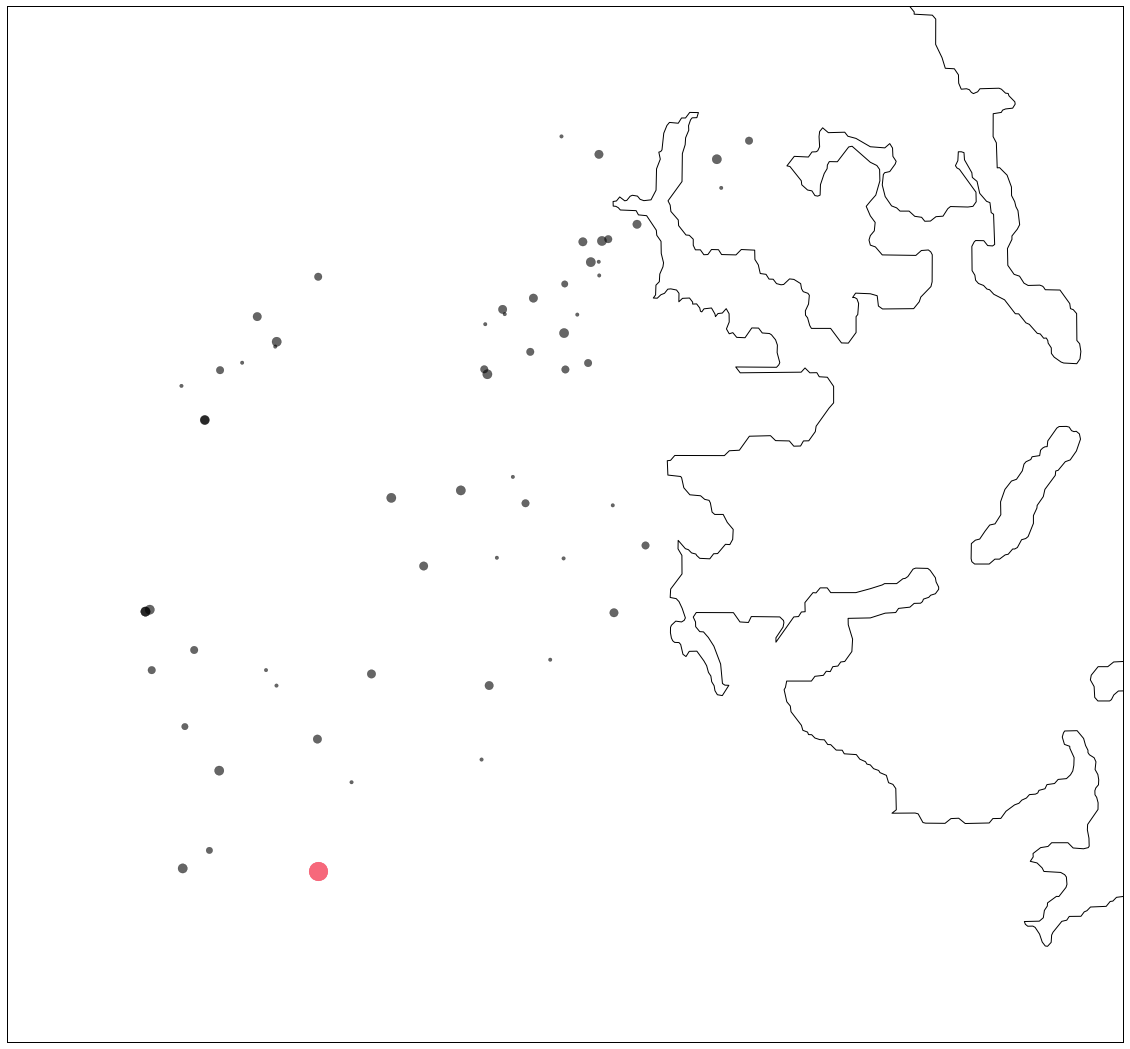

In [126]:
m.drawmapboundary(fill_color='#ffffff')
m.fillcontinents(color='#ffffff', lake_color='#ffffff', alpha=0)
m.drawcoastlines()

SchoolToShow = 'Reggie Smith School'

stoplons = df.loc[df['AssignedSchool'] == SchoolToShow].Long
stoplats = df.loc[df['AssignedSchool'] == SchoolToShow].Lat

schoollons = SchoolLoc.loc[df['AssignedSchool'] == SchoolToShow].SchoolLong
schoollats = SchoolLoc.loc[df['AssignedSchool'] == SchoolToShow].SchoolLat

stopx, stopy = m(list(stoplons), list(stoplats))
schoolx, schooly = m(list(schoollons), list(schoollats))

size = df.StopFlex * 600 + 50

m.scatter(stopx, stopy, marker='.', s = size, color = 'k', alpha = .6)
m.scatter(schoolx, schooly, marker = 'o', s = 350, c = '#F6546A', alpha=0.5)
#m.readshapefile('/Users/tylershannon/Desktop/bos_land/bos_land', 'bosshape')

plt.savefig('BPS_'+SchoolToShow, bbox_inches='tight')

# 1c. Data Visualization - Pickup Type Count Plot

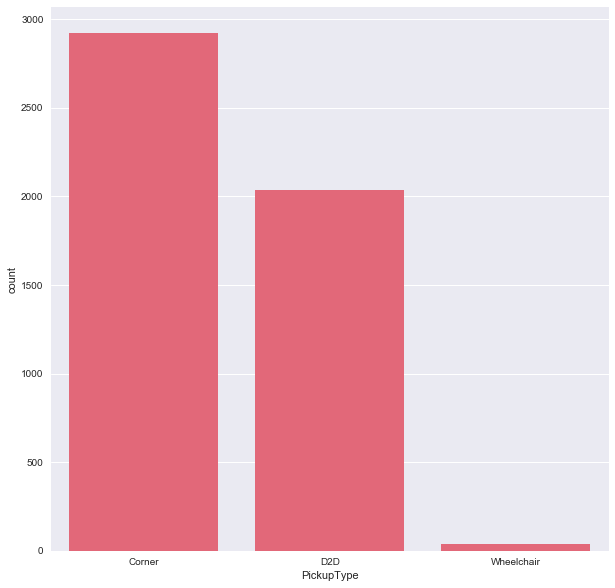

In [123]:
count_plot = sns.countplot(x= df.PickupType, data=df, color = '#F6546A')